In [ ]:
#Reference from
#https://www.kaggle.com/code/areeshaary/sentimental-analysis-using-amazon-reviews/notebook 

In [1]:
import bz2
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix,classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint
import pickle

/home/simon/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-01-26 18:12:08.438032: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-26 18:12:08.615841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 18:12:08.615900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 18:12:08.63903

In [2]:
import os
current_directory = os.getcwd()
print("Current Directory:", current_directory)

output_path='Dataset/train.ft.txt'
with bz2.open('Dataset/train.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Train Successful ❤')
output_path='Dataset/test.ft.txt'
with bz2.open('Dataset/test.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Test Successful ❤')

Current Directory: /home/simon/Documents/FinalProjectsSem/user-review-categorization
Train Successful ❤
Test Successful ❤


In [3]:
train,test,train_label,test_label=[],[],[],[]
with open('Dataset/train.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    train.append(line.split('__label__')[1][1:])
    train_label.append(line.split('__label__')[1][0])
with open('Dataset/test.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    test.append(line.split('__label__')[1][1:])
    test_label.append(line.split('__label__')[1][0])

100%|██████████████████████████████| 400000/400000 [00:00<00:00, 1347388.98it/s]


In [4]:
def clean_text(text):
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    
    
    return text

In [5]:
print('Train Length',len(train))
print('Train Label Length',len(train_label))
print('Test Length',len(test))
print('Test Label Length',len(test_label))

Train Length 3600000
Train Label Length 3600000
Test Length 400000
Test Label Length 400000


In [6]:
train_label[0],train[0]

('2',
 ' Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n')

In [7]:
train_label[0],clean_text(train[0])

('2',
 ' stuning even for the nongamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen ')

In [8]:
test_label[0],test[0]

('2',
 ' Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"\n')

In [9]:
test_label[0],clean_text(test[0])

('2',
 ' great cd my lovely pat has one of the great voices of her generation i have listened to this cd for years and i still love it when im in a good mood it makes me feel better a bad mood just evaporates like sugar in the rain this cd just oozes life vocals are jusat stuunning and lyrics just kill one of lifes hidden gems this is a desert isle cd in my book why she never made it big is just beyond me everytime i play this no matter black white young old male female everybody says one thing who was that singing ')

In [10]:
#train label
pd.DataFrame(train_label).value_counts()

1    1800000
2    1800000
dtype: int64

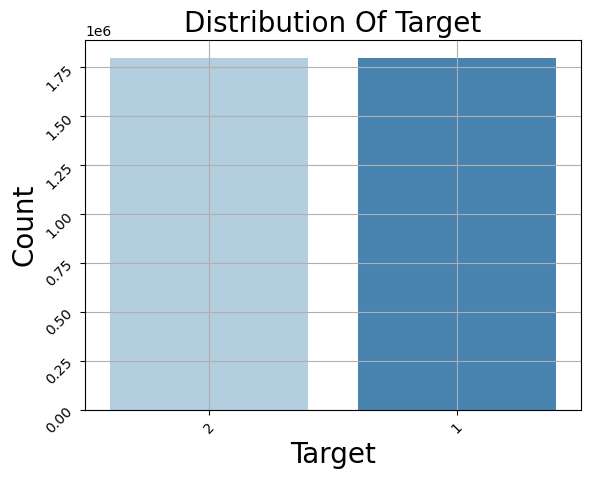

In [11]:
sns.countplot(x=pd.DataFrame(train_label)[0],palette='Blues')
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [12]:
#test label
pd.DataFrame(test_label).value_counts()

1    200000
2    200000
dtype: int64

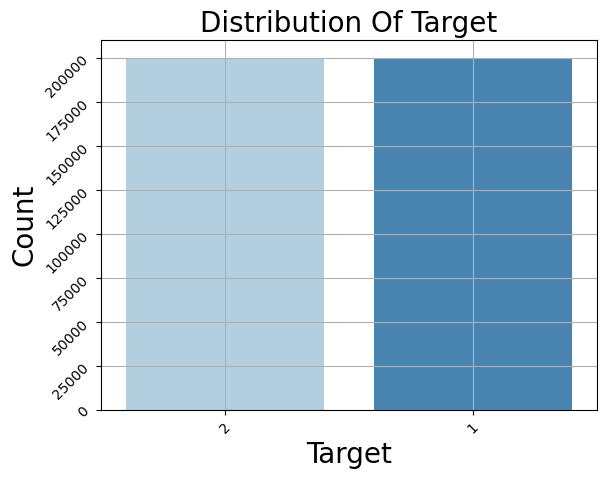

In [13]:
sns.countplot(x=pd.DataFrame(test_label)[0],palette='Blues')
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [14]:
train=pd.DataFrame(train)[0].apply(clean_text)
test=pd.DataFrame(test)[0].apply(clean_text)
train.head()

0     stuning even for the nongamer this sound trac...
1     the best soundtrack ever to anything im readi...
2     amazing this soundtrack is my favorite music ...
3     excellent soundtrack i truly like this soundt...
4     remember pull your jaw off the floor after he...
Name: 0, dtype: object

In [15]:
test.head()

0     great cd my lovely pat has one of the great v...
1     one of the best game music soundtracks for a ...
2     batteries died within a year i bought this ch...
3     works fine but maha energy is better check ou...
4     great for the nonaudiophile reviewed quite a ...
Name: 0, dtype: object

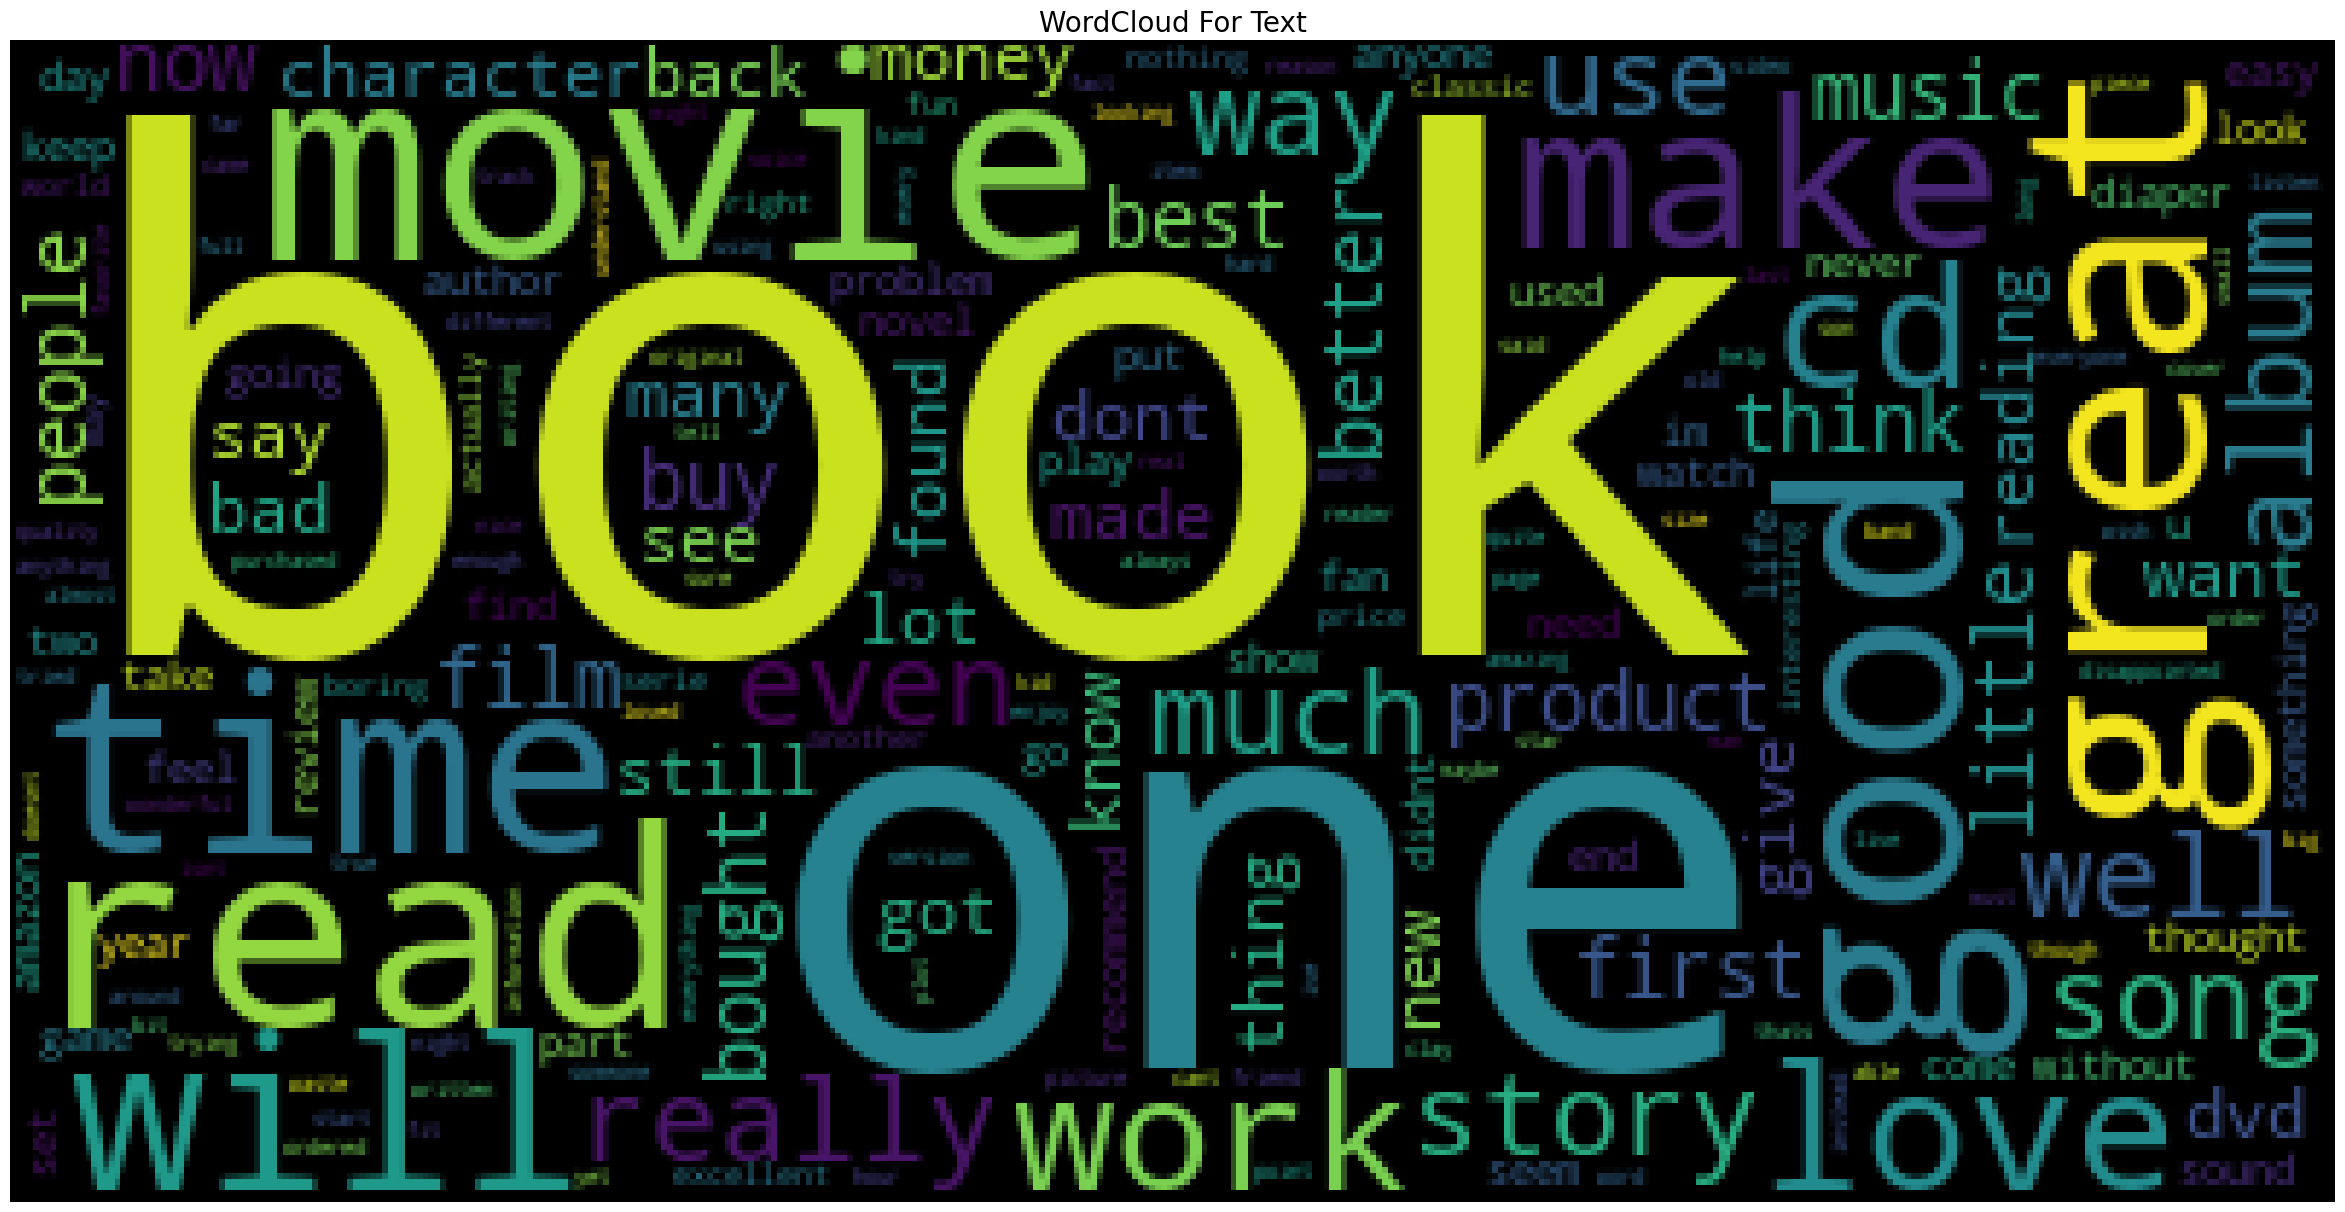

In [16]:
plt.figure(figsize=(30,20))
plt.imshow(WordCloud().generate(" ".join(train.iloc[:20000])))
plt.axis("off")
plt.title("WordCloud For Text",fontsize=20)
plt.show()